In [2]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.ensemble import IsolationForest
from sklearn.cluster import HDBSCAN
from sklearn.preprocessing import StandardScaler

funciones utiles

In [3]:
def plot_volcans(dt='1750-01-01', get = False):

    volcanes = {
    "Tambora\nVEI 7"     : {"fecha": "1812-01-01", "ha": "center", "lat": -8.25, "lon": 118},
    "Krakatau\nVEI 6"    : {"fecha": "1883-05-20", "ha": "right",  "lat": -6.1009, "lon": 105.4233},
    "Santa\nMaría\nVEI 6" : {"fecha": "1902-10-24", "ha": "center", "lat": 14.757, "lon": -91.552},
    "Novarupta\nVEI 6"   : {"fecha": "1912-06-06", "ha": "left",   "lat": 58.2655, "lon": -155.1588},
    "Pinatubo\nVEI 6"    : {"fecha": "1991-04-02", "ha": "center", "lat": 15.13, "lon": 120.35},
    }

    if get:
        return volcanes

    for nombre, data in volcanes.items():
        fecha_dt = pd.to_datetime(data['fecha'])
        if fecha_dt >= pd.to_datetime(dt):
            plt.axvline(
                fecha_dt,
                color="red",
                linestyle="--",
                alpha=0.4,
            )
            plt.text(
                fecha_dt,
                plt.ylim()[1],
                nombre,
                fontsize="smaller",
                color="red",
                ha=data["ha"],
                va="bottom",
            )
    return None


In [4]:
def cluster_city_hdb(df_city):
    scaler = StandardScaler()
    X = scaler.fit_transform(df_city)

    hdb = HDBSCAN(min_cluster_size=10, min_samples=5)
    labels = hdb.fit_predict(X)

    df_city = df_city.copy()
    df_city['hdb_label'] = labels
    df_city['hdb_is_outlier'] = labels == -1
    return df_city

In [5]:
def detect_outliers_city(df_city):

    iso = IsolationForest(
        random_state=42,
        contamination='auto'
    )

    pred = iso.fit_predict(df_city)
    scores = iso.decision_function(df_city)

    df_city = df_city.copy()
    df_city['iso_label'] = pred
    df_city['iso_score'] = scores
    df_city['is_outlier'] = df_city['iso_label'] == -1

    return df_city

In [6]:
def coord_to_float(s: str) -> float:
    sign = -1 if s[-1] in ['S', 'W'] else 1
    return sign * float(s[:-1])

Carga y procesamiento rapido de datos

In [7]:
MajorCityCsv = './datasets/GlobalLandTemperaturesByMajorCity.csv'

In [8]:
MajorCityDf = pd.read_csv(
    MajorCityCsv,
    dtype_backend='pyarrow',
    engine='pyarrow'
)
MajorCityDf['year'] = MajorCityDf.dt.dt.year
MajorCityDf['month'] = MajorCityDf.dt.dt.month
MajorCityDf = MajorCityDf.sort_values('dt').reset_index().drop(['index'], axis=1)
MajorCityDf['Latitude'] = MajorCityDf['Latitude'].apply(coord_to_float)
MajorCityDf['Longitude'] = MajorCityDf['Longitude'].apply(coord_to_float)

MajorCityDf = MajorCityDf[MajorCityDf['year'] > 1800]

cols = ['AverageTemperature', 'AverageTemperatureUncertainty']
MajorCityDf[cols] = MajorCityDf[cols].interpolate(method='linear', limit_direction='forward')

In [9]:
MajorCityDf["MA12"] = (
    MajorCityDf
    .groupby(["Country", "City"])["AverageTemperature"]
    .transform(lambda x: x.rolling(12, min_periods=1, center=True).mean())
)
MajorCityDf['dt'] = pd.to_datetime(MajorCityDf['dt'])
MajorCityDf = MajorCityDf[MajorCityDf['year'] < 2013]
MajorCityDf.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month,MA12
11754,1801-01-01,20.017,1.792,Ahmadabad,India,23.31,72.52,1801,1,19.328611
11755,1801-01-01,17.2535,1.9025,Aleppo,Syria,36.17,37.79,1801,1,18.906472
11756,1801-01-01,14.49,2.013,Alexandria,Egypt,31.35,30.16,1801,1,18.484333
11757,1801-01-01,-0.401,2.689,Ankara,Turkey,39.38,33.29,1801,1,8.398500
11758,1801-01-01,23.161,1.639,Bangalore,India,12.05,77.26,1801,1,21.196333


In [10]:
# Fuente https://www.kaggle.com/datasets/hserdaraltan/countries-by-continent

country_by_continent = pd.read_csv(
    './datasets/countries_by_continents.csv',
    dtype_backend='pyarrow',
    engine='pyarrow'
)
country_by_continent['Continent'].unique()

<ArrowExtensionArray>
['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
Length: 6, dtype: string[pyarrow]

In [11]:
MajorCityDf = MajorCityDf.merge(
    country_by_continent,
    how='left',
    on='Country'
)

In [12]:
MajorCityDf[MajorCityDf['Continent'].isna()]['Country'].unique()

<ArrowExtensionArray>
['Burma', "Côte D'Ivoire", 'Congo (Democratic Republic Of The)']
Length: 3, dtype: string[pyarrow]

In [13]:
MajorCityDf.loc[MajorCityDf['Country'] == 'Burma', 'Continent'] = 'Asia'
MajorCityDf.loc[MajorCityDf['Country'] == "Côte D'Ivoire", 'Continent'] = 'Africa'
MajorCityDf.loc[MajorCityDf['Country'] == "Congo (Democratic Republic Of The)", 'Continent'] = 'Africa'

codificación de features

In [14]:
MajorCityDf['city_encoded'], _ = pd.factorize(MajorCityDf['City'])
MajorCityDf['country_encoded'], _ = pd.factorize(MajorCityDf['Country'])
MajorCityDf['continent_encoded'],_ = pd.factorize(MajorCityDf['Continent'])
MajorCityDf.head(2)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month,MA12,Continent,city_encoded,country_encoded,continent_encoded
0,1801-01-01,20.017,1.792,Ahmadabad,India,23.31,72.52,1801,1,19.328611,Asia,0,0,0
1,1801-01-01,17.2535,1.9025,Aleppo,Syria,36.17,37.79,1801,1,18.906472,Asia,1,1,0


In [15]:
MajorCityDf['MA12+D'] = MajorCityDf['MA12'] + MajorCityDf['AverageTemperatureUncertainty']
MajorCityDf['MA12-D'] = MajorCityDf['MA12'] - MajorCityDf['AverageTemperatureUncertainty']

Isolation Forest

In [16]:
feats = [
    'MA12', 'Latitude', 'Longitude', 'city_encoded',
    'country_encoded',
    'month', 'year', 'MA12+D', 'MA12-D', 'continent_encoded'
]

In [17]:
MajorCityDf = MajorCityDf.combine_first(MajorCityDf.groupby('City', group_keys=False)[feats].apply(detect_outliers_city))

In [18]:
MajorCityDf.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Continent,Country,Latitude,Longitude,MA12,MA12+D,MA12-D,city_encoded,continent_encoded,country_encoded,dt,is_outlier,iso_label,iso_score,month,year
0,20.017,1.792,Ahmadabad,Asia,India,23.31,72.52,19.328611,21.120611,17.536611,0,0,0,1801-01-01,True,-1,-0.158232,1,1801
1,17.2535,1.9025,Aleppo,Asia,Syria,36.17,37.79,18.906472,20.808972,17.003972,1,0,1,1801-01-01,True,-1,-0.118763,1,1801
2,14.49,2.013,Alexandria,Africa,Egypt,31.35,30.16,18.484333,20.497333,16.471333,2,1,2,1801-01-01,True,-1,-0.177264,1,1801
3,-0.401,2.689,Ankara,Europe,Turkey,39.38,33.29,8.398500,11.0875,5.7095,3,2,3,1801-01-01,True,-1,-0.142044,1,1801
4,23.161,1.639,Bangalore,Asia,India,12.05,77.26,21.196333,22.835333,19.557333,4,0,0,1801-01-01,True,-1,-0.149086,1,1801


In [19]:
top_rare = MajorCityDf.sort_values('iso_score').head(50)
top_rare.head(2)

,AverageTemperature,AverageTemperatureUncertainty,City,Continent,Country,Latitude,Longitude,MA12,MA12+D,MA12-D,city_encoded,continent_encoded,country_encoded,dt,is_outlier,iso_label,iso_score,month,year
21299,27.0695,2.24325,Shenyang,Asia,China,40.99,123.55,22.534500,24.77775,20.29125,57,0,19,1838-08-01,True,-1,-0.291708,8,1838
21365,26.62975,1.49525,Shenyang,Asia,China,40.99,123.55,19.879271,21.374521,18.384021,57,0,19,1838-09-01,True,-1,-0.289145,9,1838


In [20]:
city_taget = 'Luanda'
country_taget = 'Angola'

In [21]:
top_rare[top_rare['City'] == city_taget].sort_values('dt')

,AverageTemperature,AverageTemperatureUncertainty,City,Continent,Country,Latitude,Longitude,MA12,MA12+D,MA12-D,city_encoded,continent_encoded,country_encoded,dt,is_outlier,iso_label,iso_score,month,year
46598,10.285,0.893667,Luanda,Africa,Angola,-8.84,13.78,14.559750,15.453417,13.666083,95,1,45,1862-11-01,True,-1,-0.264302,11,1862
46697,7.373667,1.607,Luanda,Africa,Angola,-8.84,13.78,14.565056,16.172056,12.958056,95,1,45,1862-12-01,True,-1,-0.267524,12,1862
46796,6.627667,2.373,Luanda,Africa,Angola,-8.84,13.78,14.501306,16.874306,12.128306,95,1,45,1863-01-01,True,-1,-0.276434,1,1863
46895,7.223333,2.764,Luanda,Africa,Angola,-8.84,13.78,14.455056,17.219056,11.691056,95,1,45,1863-02-01,True,-1,-0.269114,2,1863
46994,10.87,0.818667,Luanda,Africa,Angola,-8.84,13.78,14.382167,15.200833,13.5635,95,1,45,1863-03-01,True,-1,-0.259167,3,1863
47093,13.4,1.246333,Luanda,Africa,Angola,-8.84,13.78,14.397000,15.643333,13.150667,95,1,45,1863-04-01,True,-1,-0.260195,4,1863
47489,22.348333,1.560333,Luanda,Africa,Angola,-8.84,13.78,14.365306,15.925639,12.804972,95,1,45,1863-08-01,True,-1,-0.255986,8,1863
47786,10.296,0.989333,Luanda,Africa,Angola,-8.84,13.78,14.465139,15.454472,13.475806,95,1,45,1863-11-01,True,-1,-0.258634,11,1863
47885,7.319333,1.199,Luanda,Africa,Angola,-8.84,13.78,14.624250,15.82325,13.42525,95,1,45,1863-12-01,True,-1,-0.259774,12,1863
47984,7.249,0.699333,Luanda,Africa,Angola,-8.84,13.78,14.724444,15.423778,14.025111,95,1,45,1864-01-01,True,-1,-0.267555,1,1864


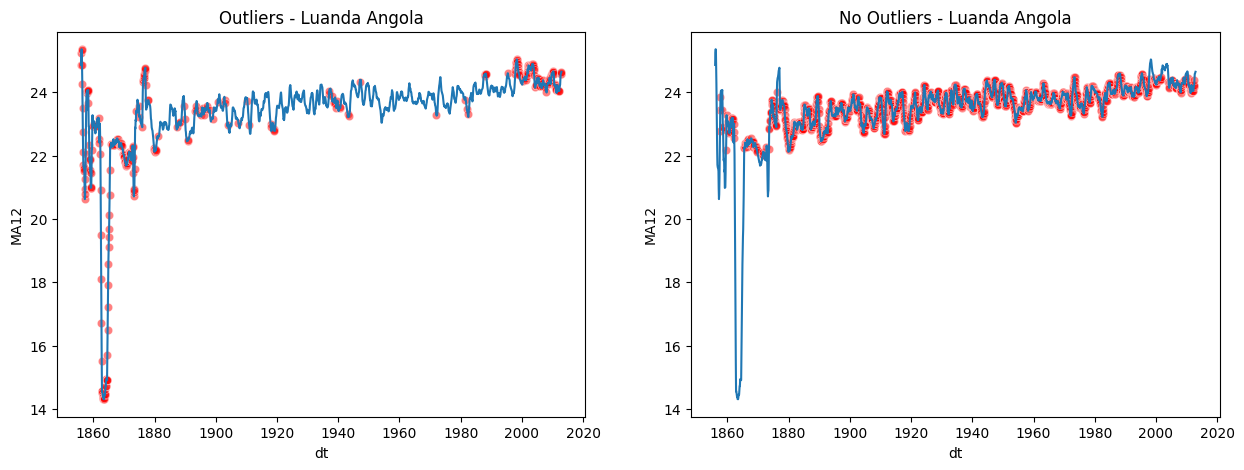

In [22]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title(f'Outliers - {city_taget} {country_taget}')

sn.lineplot(
    MajorCityDf[MajorCityDf['City'] == city_taget],
    x='dt',
    y='MA12'
)

# sn.lineplot(
#     MajorCityDf[MajorCityDf['City'] == city_taget],
#     x='dt',
#     y='MA12+D',
#     alpha=0.2
# )
# sn.lineplot(
#     MajorCityDf[MajorCityDf['City'] == city_taget],
#     x='dt',
#     y='MA12-D',
#     alpha=0.2
# )

sn.scatterplot(
    MajorCityDf[(MajorCityDf['City'] == city_taget) & ( MajorCityDf['is_outlier'] == True )],
    x='dt',
    y='MA12',
    color='red',
    alpha=0.5
)

plt.subplot(1,2,2)
plt.title(f'No Outliers - {city_taget} {country_taget}')

sn.lineplot(
    MajorCityDf[MajorCityDf['City'] == city_taget],
    x='dt',
    y='MA12'
)

# sn.lineplot(
#     MajorCityDf[MajorCityDf['City'] == city_taget],
#     x='dt',
#     y='MA12+D',
#     alpha=0.2
# )
# sn.lineplot(
#     MajorCityDf[MajorCityDf['City'] == city_taget],
#     x='dt',
#     y='MA12-D',
#     alpha=0.2
# )

sn.scatterplot(
    MajorCityDf[(MajorCityDf['City'] == city_taget) & ( MajorCityDf['is_outlier'] == False )],
    x='dt',
    y='MA12',
    color='red',
    alpha=0.5
)

plt.show()




In [ ]:
volcanes = plot_volcans(get=True)
lats = [v["lat"] for v in volcanes.values()]
lons = [v["lon"] for v in volcanes.values()]
texts = [f"{nombre.replace('\n', ' ')}<br>{datos['fecha']}" for nombre, datos in volcanes.items()]


fig = go.Figure(
    go.Scattergeo(
        lon=lons,
        lat=lats,
        text=texts,
        mode="markers+text",
        textposition="top center",
        marker=dict(size=10),
    )
)


fig.update_layout(
    title="Grandes erupciones volcánicas (VEI ≥ 6)",
    geo=dict(
        projection_type="natural earth",
        showcoastlines=True,
        coastlinecolor="black",
        showland=True,
        landcolor="rgb(217, 217, 217)",
        showcountries=True,
    ),
)


fig.show()

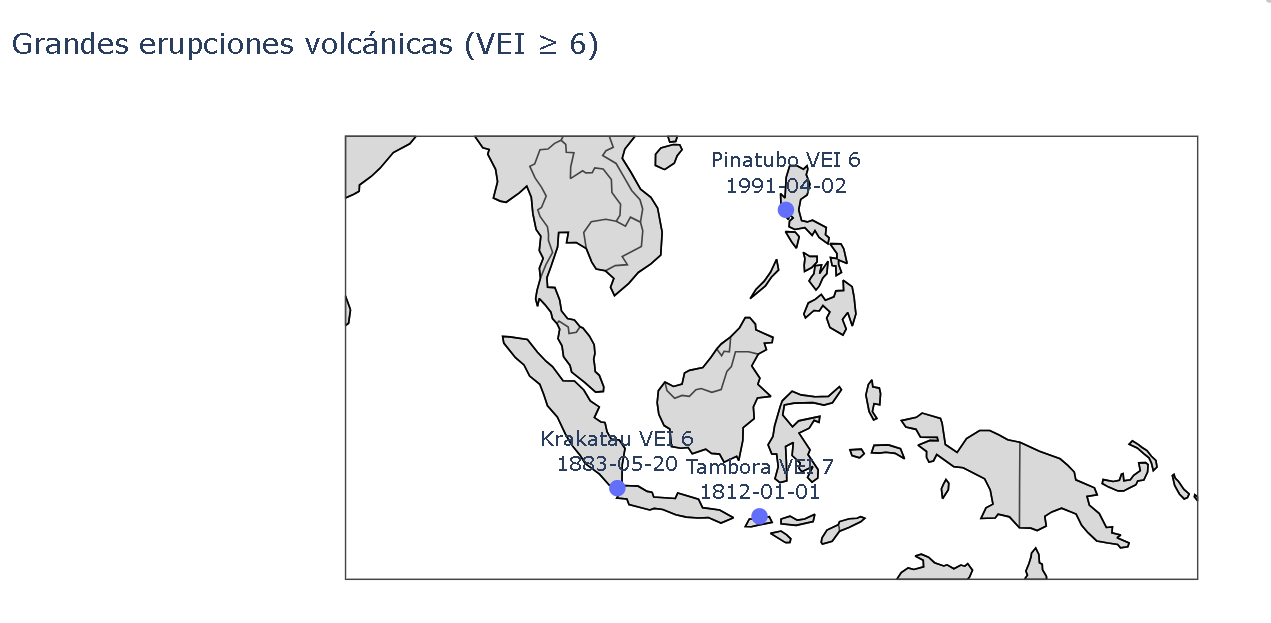
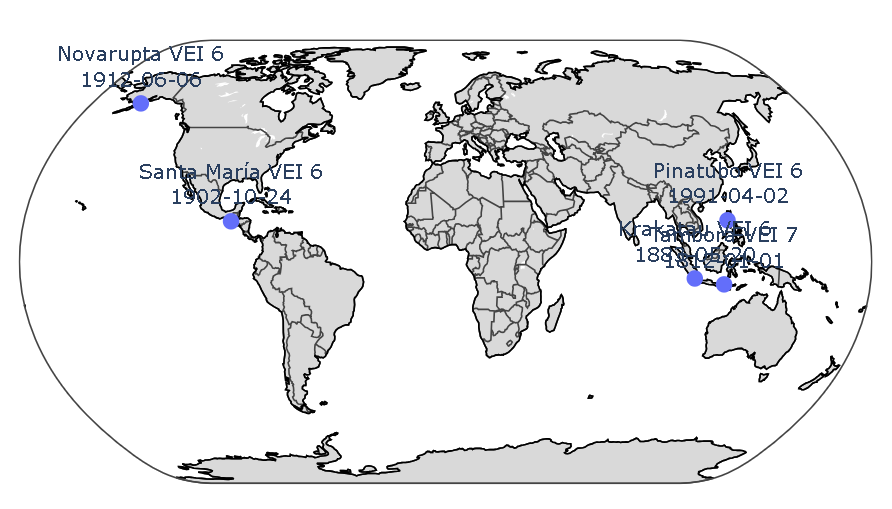

Oceania te toca

{'Tambora\nVEI 7': {'fecha': '1812-01-01', 'ha': 'center', 'lat': -8.25, 'lon': 118}, 'Krakatau\nVEI 6': {'fecha': '1883-05-20', 'ha': 'right', 'lat': -6.1009, 'lon': 105.4233}, 'Santa\nMaría\nVEI 6': {'fecha': '1902-10-24', 'ha': 'center', 'lat': 14.757, 'lon': -91.552}, 'Novarupta\nVEI 6': {'fecha': '1912-06-06', 'ha': 'left', 'lat': 58.2655, 'lon': -155.1588}, 'Pinatubo\nVEI 6': {'fecha': '1991-04-02', 'ha': 'center', 'lat': 15.13, 'lon': 120.35}}


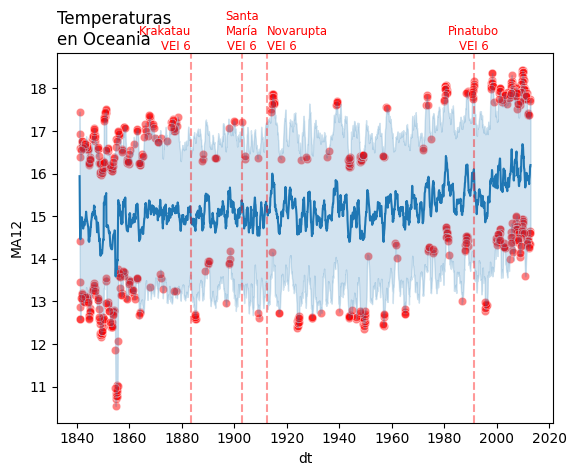

In [26]:
continent_target = 'Oceania'


sn.scatterplot(
    (MajorCityDf[(MajorCityDf['Continent'] == continent_target) & ( MajorCityDf['is_outlier'] == True )]).sort_values('iso_score').head(700),
    x='dt',
    y='MA12',
    color='red',
    alpha=0.5
)

sn.lineplot(
    MajorCityDf[MajorCityDf['Continent'] == continent_target],
    x='dt',
    y='MA12'
)

plt.title(f'Temperaturas \nen {continent_target}', loc='left')

plot_volcans( dt= '1840-01-01' )

print(plot_volcans(get=True))

https://www.quora.com/Can-volcanic-eruptions-cause-climate-change-If-so-what-are-the-effects-and-how-long-do-they-last

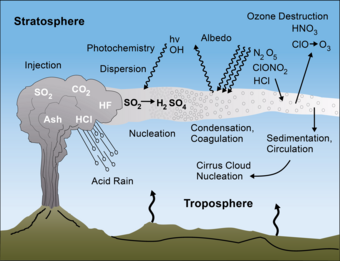

# HDBscan | Outliers

Se analiza las temperaturas de cada ciudad cON HDBScan. Se seinte que es más rápido que Isolation Forest

In [27]:
MajorCityDf = MajorCityDf.combine_first(MajorCityDf.groupby('City', group_keys=False)[feats].apply(cluster_city_hdb))

Se ve que DBScan categoriza a menos puntos de temperatura como Outliers

In [29]:
print(np.sum( MajorCityDf['hdb_is_outlier'] == True ))
print(MajorCityDf.shape)

27855
(226523, 21)


In [30]:
print(np.sum(MajorCityDf['is_outlier'] == True))
print(MajorCityDf.shape)

50081
(226523, 21)


A diferencia del gráfico anterior, no se grafican el top de 700 outliers, ya que no tenemos un score para ordenarlos (o no sé todavía si la herramiente ofrece un score).

{'Tambora\nVEI 7': {'fecha': '1812-01-01', 'ha': 'center', 'lat': -8.25, 'lon': 118}, 'Krakatau\nVEI 6': {'fecha': '1883-05-20', 'ha': 'right', 'lat': -6.1009, 'lon': 105.4233}, 'Santa\nMaría\nVEI 6': {'fecha': '1902-10-24', 'ha': 'center', 'lat': 14.757, 'lon': -91.552}, 'Novarupta\nVEI 6': {'fecha': '1912-06-06', 'ha': 'left', 'lat': 58.2655, 'lon': -155.1588}, 'Pinatubo\nVEI 6': {'fecha': '1991-04-02', 'ha': 'center', 'lat': 15.13, 'lon': 120.35}}


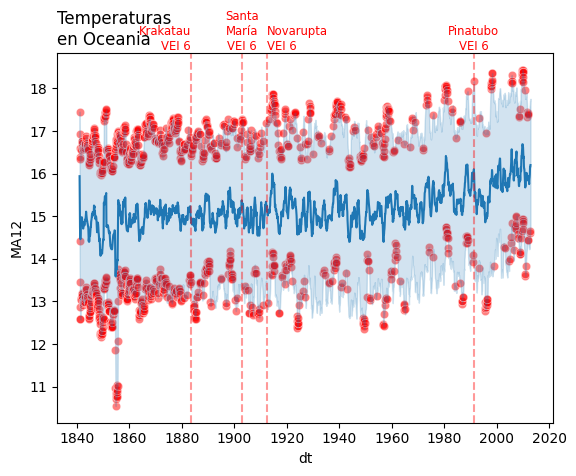

In [34]:
continent_target = 'Oceania'


sn.scatterplot(
    (MajorCityDf[(MajorCityDf['Continent'] == continent_target) & ( MajorCityDf['hdb_label'] == -1 )]),
    x='dt',
    y='MA12',
    color='red',
    alpha=0.5
)

sn.lineplot(
    MajorCityDf[MajorCityDf['Continent'] == continent_target],
    x='dt',
    y='MA12'
)

plt.title(f'Temperaturas \nen {continent_target}', loc='left')

plot_volcans( dt= '1840-01-01' )

print(plot_volcans(get=True))